### Import Libraries

In [1]:
import os
import time
import warnings
from dotenv import load_dotenv

import pandas as pd
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, precision_recall_fscore_support,
    accuracy_score, f1_score, matthews_corrcoef, 
    confusion_matrix, ConfusionMatrixDisplay
)

from feature_engine.datetime import DatetimeFeatures

# Training
import torch
from pytorch_lightning.callbacks.early_stopping import EarlyStopping as PLEarlyStopping

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import TSMixerModel
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import MissingValuesFiller


# Data processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Model evaluation
from sklearn.metrics import f1_score, classification_report, roc_auc_score

# Hyperparameter tuning
import optuna
from optuna.integration import PyTorchLightningPruningCallback

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

### Load Dataset

In [2]:
load_dotenv()
DATA_DIR = os.getenv("IMP_DATASET")

# Load the dataset
dataset = pd.read_csv(DATA_DIR)

# Remove the 'Unnamed: 0' column if it exists
if "Unnamed: 0" in dataset.columns:
    dataset.drop(columns=["Unnamed: 0"], inplace=True)
    
dataset.head(5)

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,timestamp,machine_status
0,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,2018-04-01 00:00:00,NORMAL
1,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,2018-04-01 00:01:00,NORMAL
2,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,2018-04-01 00:02:00,NORMAL
3,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,2018-04-01 00:03:00,NORMAL
4,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,2018-04-01 00:04:00,NORMAL


In [3]:
# Get all machine status labels
all_labels = ['BROKEN', 'NORMAL', 'RECOVERING']

# Generate encoding maps for labels
label2id = {l: i for i,l in enumerate(all_labels)}
id2label = {v:k for k,v in label2id.items()}
id2label

{0: 'BROKEN', 1: 'NORMAL', 2: 'RECOVERING'}

### View Distribution of Machine Status

C:\Users\yukse\AppData\Local\Temp\ipykernel_8172\1237394390.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(
C:\Users\yukse\AppData\Local\Temp\ipykernel_8172\1237394390.py:7: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  bar_plot = sns.barplot(


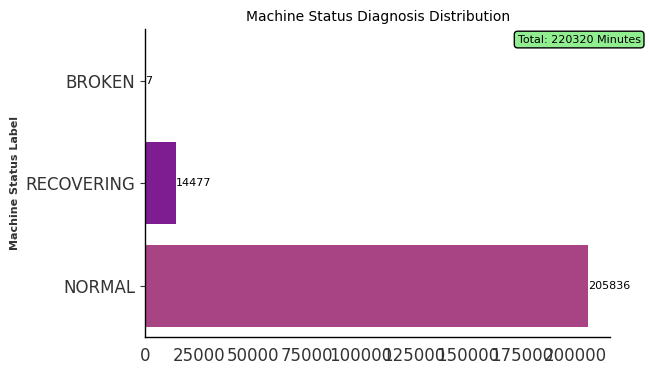

In [4]:
# View Diagnosis Distribution
fig = plt.figure(figsize=(6, 4))
plt.title('Machine Status Diagnosis Distribution', fontsize=10)

status_distribution = dataset['machine_status'].value_counts().sort_values()

bar_plot = sns.barplot(
    x=status_distribution.values,
    y=status_distribution.keys(),
    palette=sns.color_palette("plasma"),
    orient="h"
)

for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=8)
    
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Machine Status Label', fontsize=8)

text_params = {
    'x'       : status_distribution.max() * 0.98,
    'y'       : -0.4,
    's'       : f"Total: {len(dataset)} Minutes", 
    'size'    : 8,
    'color'   : "black",
    'ha'      : "center", 
    'va'      : "center",
    'bbox'    : dict(boxstyle="round", fc=("lightgreen"),ec=("black"))
}
plt.text(**text_params)
plt.grid(False)
sns.despine()

### Preprocessing

In [5]:
# Replace 'BROKEN' with 'RECOVERING'
print("--- Before Conversion ---")
print(dataset['machine_status'].value_counts())
dataset.loc[dataset['machine_status'] == 'BROKEN', 'machine_status'] = 'RECOVERING'
print("\n\n--- After Conversion ---")
print(dataset['machine_status'].value_counts())

--- Before Conversion ---
machine_status
NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: count, dtype: int64


--- After Conversion ---
machine_status
NORMAL        205836
RECOVERING     14484
Name: count, dtype: int64


In [6]:
# Encode categorical variables
label_encoder = LabelEncoder()

dataset['target'] = label_encoder.fit_transform(dataset['machine_status'])

dataset.head(5)

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,timestamp,machine_status,target
0,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,2018-04-01 00:00:00,NORMAL,0
1,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,2018-04-01 00:01:00,NORMAL,0
2,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,2018-04-01 00:02:00,NORMAL,0
3,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,2018-04-01 00:03:00,NORMAL,0
4,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,2018-04-01 00:04:00,NORMAL,0


In [7]:
label_encoder.classes_

array(['NORMAL', 'RECOVERING'], dtype=object)

In [8]:
# Generate datetime features
def apply_datetime_features(dataframe, variable_name="Date"):

    dtfs = DatetimeFeatures(
        variables=variable_name,
        features_to_extract=["day_of_year", "month", "hour"],
        drop_original=False
    )

    dfs_transformed = dtfs.fit_transform(dataframe)

    return dfs_transformed

In [9]:
# Apply datetime features
dataset_transformed = apply_datetime_features(dataset, variable_name="timestamp")
dataset_transformed.head(5)

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_48,sensor_49,sensor_50,sensor_51,timestamp,machine_status,target,timestamp_day_of_year,timestamp_month,timestamp_hour
0,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,157.9861,67.70834,243.0556,201.3889,2018-04-01 00:00:00,NORMAL,0,91,4,0
1,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,157.9861,67.70834,243.0556,201.3889,2018-04-01 00:01:00,NORMAL,0,91,4,0
2,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,155.9606,67.12963,241.3194,203.7037,2018-04-01 00:02:00,NORMAL,0,91,4,0
3,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,155.9606,66.84028,240.4514,203.1250,2018-04-01 00:03:00,NORMAL,0,91,4,0
4,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,158.2755,66.55093,242.1875,201.3889,2018-04-01 00:04:00,NORMAL,0,91,4,0


In [10]:
# Assign System Failures To Groups
group_idx = 0
anomaly_group = [0]
target_series = dataset_transformed['machine_status'].to_list()

# Generate groups for each anomaly case
for _ in range(1, len(dataset_transformed)):
    if (target_series[_] == 'NORMAL' and target_series[_ - 1] == 'RECOVERING'):
        group_idx += 1
        
    anomaly_group.append(group_idx)

# Add groups to dataset
dataset_transformed['anomaly_group'] = np.array(anomaly_group).astype(np.int32)
dataset_transformed['anomaly_group']

0         0
1         0
2         0
3         0
4         0
         ..
220315    7
220316    7
220317    7
220318    7
220319    7
Name: anomaly_group, Length: 220320, dtype: int32

In [11]:
groups = list(set(dataset_transformed['anomaly_group']))
group_dict = {}

# Get system failure instance label counts
for _ in groups:
    group_dict[_] = dict(
        dataset_transformed[dataset_transformed['anomaly_group'] == _]
        ['machine_status']
        .value_counts()
    )
# Create summary df for system failure counts    
group_df = pd.DataFrame(group_dict).T.fillna(0).astype(np.int32)
group_df

,NORMAL,RECOVERING
0,17155,945
1,6410,3111
2,41697,1313
3,7159,606
4,49644,8391
5,4700,42
6,25267,76
7,53804,0


In [12]:
# Initialise lag feature variables
lag_features = []
n_lags = 10
feaures_added = False

In [13]:
# Define list of sensors
ignored_columns = [
    'timestamp', 'machine_status', 'target', 'timestamp_day_of_year', 'timestamp_month', 'timestamp_hour', 'anomaly_group'
]
sensors = [_ for _ in dataset_transformed.columns if _ not in ignored_columns]

if not (feaures_added):
    for lag in range(n_lags):
        lag_sensors = {}

        for sensor in sensors:
            # Create lag feature name
            sensor_feature = sensor + f'_lag_{n_lags}'
            
            # Generate lag feature
            dataset_transformed[sensor_feature] = dataset_transformed[sensor].shift(n_lags)
                
    # Set flag to True to avoid adding duplications
    feaures_added = True
else:
    print('Features have already been added!')

In [14]:
# Drop rows with NaN values
dataset_transformed = dataset_transformed.dropna().reset_index(drop=True)
dataset_transformed.head(10)

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42_lag_10,sensor_43_lag_10,sensor_44_lag_10,sensor_45_lag_10,sensor_46_lag_10,sensor_47_lag_10,sensor_48_lag_10,sensor_49_lag_10,sensor_50_lag_10,sensor_51_lag_10
0,2.464410,47.48264,53.12500,46.397568,637.7314,76.05148,13.41146,16.16753,15.65393,15.11863,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889
1,2.444734,47.91666,53.16840,46.397568,635.6482,74.58654,13.41146,16.16753,15.84925,15.11863,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889
2,2.460474,48.26389,53.12500,46.397568,630.0926,76.95988,13.34635,16.16753,15.73351,15.01013,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037
3,2.448669,48.43750,53.16840,46.397568,638.6574,75.67310,13.31742,16.16753,15.84925,15.16927,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250
4,2.453588,48.56771,53.16840,46.397568,632.4074,80.65949,13.38976,16.13136,15.53096,15.08970,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889
5,2.455556,48.39410,53.12500,46.397570,642.3611,78.13193,13.35359,16.21094,15.45139,15.12587,...,31.250000,42.70833,38.773150,63.65741,51.79398,38.773150,164.6412,66.55093,241.6088,201.6782
6,2.449653,48.39410,53.16840,46.310760,630.2084,77.89381,13.30295,16.16753,15.89265,15.08247,...,31.510420,43.22916,38.194440,61.92130,51.79398,39.062500,171.8750,67.70834,240.1620,200.2315
7,2.463426,48.48090,53.68924,46.310760,643.6343,77.30572,13.34635,16.16753,15.61777,15.01013,...,31.510416,42.96875,38.194443,59.60648,50.92593,39.351850,178.5301,68.57639,241.3194,201.0995
8,2.445718,48.61111,53.12500,46.310760,632.9861,76.66199,13.34635,16.21094,15.81308,15.05353,...,31.510416,42.18750,38.194440,57.87037,50.63657,39.351850,182.0023,69.44444,243.0556,201.6782
9,2.464410,48.61111,53.16840,46.310760,644.3287,78.49116,13.34635,16.13136,15.70457,15.08247,...,31.510416,41.66666,39.062500,56.42361,50.63657,39.062500,186.6319,69.73380,246.5278,200.8102


### Hyperparameter Tuning

In [15]:
# Generate Train & Test splits based on assigned groups
train_df = dataset_transformed[
    ~dataset_transformed['anomaly_group'].isin([5, 6, 7])
]

test_df = dataset_transformed[
    dataset_transformed['anomaly_group'].isin([5, 6, 7])
].reset_index(drop=True)

In [16]:
# Drop unnecessary columns
train_df.drop(columns=['anomaly_group'], inplace=True)
test_df.drop(columns=['anomaly_group'], inplace=True)

C:\Users\yukse\AppData\Local\Temp\ipykernel_8172\714826828.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=['anomaly_group'], inplace=True)


In [18]:
print(train_df.columns)

Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       ...
       'sensor_42_lag_10', 'sensor_43_lag_10', 'sensor_44_lag_10',
       'sensor_45_lag_10', 'sensor_46_lag_10', 'sensor_47_lag_10',
       'sensor_48_lag_10', 'sensor_49_lag_10', 'sensor_50_lag_10',
       'sensor_51_lag_10'],
      dtype='object', length=108)


In [19]:
target_coulumns = 'target'
time_column_name = 'timestamp'
time_features = [
    'timestamp_day_of_year', 
    'timestamp_month', 
    'timestamp_hour'
]
covariate_cols = [
    *time_features, 
    *sensors, 
    *lag_features
]

In [20]:
# Convert DataFrame into Darts TimeSeries format
train_target_ts = TimeSeries.from_dataframe(train_df, value_cols=target_coulumns, time_col=time_column_name, fill_missing_dates=True)
train_covariates_ts = TimeSeries.from_dataframe(train_df, value_cols=covariate_cols, time_col=time_column_name, fill_missing_dates=True)

test_target_ts = TimeSeries.from_dataframe(test_df, value_cols=target_coulumns, time_col=time_column_name, fill_missing_dates=True)
test_covariates_ts = TimeSeries.from_dataframe(test_df, value_cols=covariate_cols, time_col=time_column_name, fill_missing_dates=True)

In [21]:
# Scale Covariates
covariate_scaler = Scaler(StandardScaler())

train_covariates_ts_scaled = covariate_scaler.fit_transform(train_covariates_ts)
test_covariates_ts_scaled = covariate_scaler.transform(test_covariates_ts)

In [22]:
# Define objective function for Optuna
def objective(trial: optuna.trial.Trial) -> float:

    # Hyperparameters to tune for TSMixerModel
    in_len = trial.suggest_int("in_len", 12960, 30240, step=256)
    out_len = 4320  
    hidden_size = trial.suggest_int("hidden_size", 32, 256, step=16)
    ff_size = trial.suggest_int("ff_size", 64, 256, step=16) # Feed-forward layer size
    num_blocks = trial.suggest_int("num_blocks", 1, 4)    # Number of TSMixer blocks
    dropout = trial.suggest_float("dropout", 0.01, 0.3)
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    activation = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU", "GELU", "Tanh", "Sigmoid"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32])

    # Data length checks
    if len(train_target_ts) < in_len + out_len or \
       len(test_target_ts) < out_len : # Ensure test set is also long enough
        print(f"Trial {trial.number} pruned: Data length insufficient.")
        raise optuna.exceptions.TrialPruned()
    

    # Callbacks for PyTorch Lightning
    pruner = PyTorchLightningPruningCallback(trial, monitor="val_loss")
    early_stopper = PLEarlyStopping("val_loss", min_delta=0.001, patience=20, verbose=False) # Reduced patience
    callbacks = [pruner, early_stopper]

    pl_trainer_kwargs = {
        "accelerator": "auto", # Uses GPU if available, else CPU
        "callbacks": callbacks,
        "enable_progress_bar": True,
    }

    torch.manual_seed(42) # For reproducibility per trial

    # Build the TSMixer model
    model = TSMixerModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        hidden_size=hidden_size,
        ff_size=ff_size,
        num_blocks=num_blocks,
        batch_size=batch_size,
        activation=activation,
        n_epochs=15, # Max epochs; early stopping will manage the actual number
        nr_epochs_val_period=1, # How often to check validation loss
        dropout=dropout,
        optimizer_kwargs={"lr": lr},
        likelihood=QuantileRegression(), # For probabilistic forecasts -> ROC AUC on median
        pl_trainer_kwargs=pl_trainer_kwargs,
        model_name=f"TSMixer_Pump_Trial_{trial.number}",
        force_reset=True, # Ensures fresh model per trial
        save_checkpoints=False, # No need to save checkpoints during Optuna
    )

    try:
        # Train the model
        # Darts models use their own internal validation split during .fit() if val_series is provided
        model.fit(
            series=train_target_ts,
            past_covariates=train_covariates_ts_scaled,
            verbose=True
        )

        preds_ts = model.predict(
            n=out_len,
            series=test_target_ts, # History of target to condition on
            past_covariates=test_covariates_ts_scaled,  # Covariates for the validation period
            num_samples=100,  # Number of samples for quantile regression
        )


        # Get the median TimeSeries using the correct method name
        median_pred_ts = preds_ts.quantile_timeseries(quantile=0.5)

        # Extract the numpy array from that TimeSeries
        pred_scores_per_class = median_pred_ts.values()

        # Get the predicted class labels (this logic was already correct)
        predicted_class_labels = np.argmax(pred_scores_per_class, axis=1).flatten()

        # Get actual labels from the validation set
        actual_target_matrix_eval = test_target_ts.values(copy=True)
        actual_class_labels_eval = np.argmax(actual_target_matrix_eval, axis=1).flatten()

        # Check lengths before scoring
        if len(actual_class_labels_eval) != len(predicted_class_labels):
            print(f"FATAL: Mismatch in prediction/actual lengths. Actual: {len(actual_class_labels_eval)}, Pred: {len(predicted_class_labels)}")
        
        # Ensure lengths match for evaluation
        min_eval_len = min(len(actual_class_labels_eval), len(predicted_class_labels))

        if min_eval_len < 1: # Need at least one point to evaluate
            print(f"Warning: Prediction length ({min_eval_len}) on validation set is too short for trial {trial.number}.")

        actual_class_labels_eval = actual_class_labels_eval[:min_eval_len]
        predicted_class_labels = predicted_class_labels[:min_eval_len]

        # Calculate F1 Score
        score = f1_score(actual_class_labels_eval, predicted_class_labels, average='weighted', zero_division=0)
        print(f"Trial {trial.number}: F1 Score = {score:.4f}")
        
        objective_value = 1.0 - score # We want to minimize the objective, so we return 1 - F1 score

        if np.isnan(objective_value) or np.isinf(objective_value):
            print(f"Warning: Objective value is NaN/inf for trial {trial.number}. F1 Score: {score}. Returning inf.")
            return float('inf')

        return objective_value

    except optuna.exceptions.TrialPruned:
        raise 
    except RuntimeError as e: # Catch PyTorch/CUDA errors
        if "CUDA out of memory" in str(e) or "Address already in use" in str(e):
            print(f"Optuna trial {trial.number} failed with RuntimeError (likely CUDA OOM or port issue): {e}. Pruning.")
            raise optuna.exceptions.TrialPruned() # Prune if it's a resource issue
        print(f"Optuna trial {trial.number} failed with RuntimeError: {e}")
        return float('inf') 
    except ValueError as e: 
        print(f"Optuna trial {trial.number} - ValueError: {e}. Returning bad core (1.0).")
        return 1.0
    except Exception as e: # Catch any other unexpected errors
        print(f"Optuna trial {trial.number} failed with an unexpected error: {e}")
        return float('inf')


# for convenience, print some optimization trials information
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
# Optuna Hyperparameter Tuning
n_optuna_trials = 250
print(f"\n--- Starting Optuna Hyperparameter Tuning ({n_optuna_trials} trials) ---")
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=n_optuna_trials, callbacks=[print_callback])

[I 2025-06-18 12:08:36,466] A new study created in memory with name: no-name-7943ba42-63ca-4268-87f5-0ffc20ecdd90



--- Starting Optuna Hyperparameter Tuning (250 trials) ---


c:\Users\yukse\Desktop\Yuksel\Yucas\NLP\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [12960, 30240] and step=256, but the range is not divisible by `step`. It will be replaced by [12960, 30112].
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 2000 Ada Generation Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_cri

Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...
[I 2025-06-18 12:59:30,312] Trial 0 finished with value: inf and parameters: {'in_len': 16288, 'hidden_size': 80, 'ff_size': 128, 'num_blocks': 4, 'dropout': 0.06644445829948137, 'lr': 0.0010741017144606036, 'activation': 'Sigmoid', 'batch_size': 32}. Best is trial 0 with value: inf.


Optuna trial 0 failed with an unexpected error: name 'exit' is not defined
Current value: inf, Current params: {'in_len': 16288, 'hidden_size': 80, 'ff_size': 128, 'num_blocks': 4, 'dropout': 0.06644445829948137, 'lr': 0.0010741017144606036, 'activation': 'Sigmoid', 'batch_size': 32}
Best value: inf, Best params: {'in_len': 16288, 'hidden_size': 80, 'ff_size': 128, 'num_blocks': 4, 'dropout': 0.06644445829948137, 'lr': 0.0010741017144606036, 'activation': 'Sigmoid', 'batch_size': 32}


c:\Users\yukse\Desktop\Yuksel\Yucas\NLP\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [12960, 30240] and step=256, but the range is not divisible by `step`. It will be replaced by [12960, 30112].
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 99.1 M | train
6 | feature_mixing_hist | _FeatureMixing   | 1.3 M  | train
7 | conditional_mixer   | ModuleLis

Training: |          | 0/? [00:00<?, ?it/s]